In [1]:
import numpy as np
import pandas as pd
import shap
import os
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

from xgboost import XGBClassifier

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.chdir('/Users/appus/Downloads/input_files')
path=os.getcwd()
print(path)

C:\Users\appus\Downloads\input_files


In [4]:
#Load the dataset
df=pd.read_csv('Wholesale customers data.csv')
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


We can see that Channel variable contains values as 1 and 2.These two values classify the customers from two different channels as

1. for Horeca (Hotel/Retail/Café) customers and
2. for Retail channel (nominal) customers.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [6]:
#Now, let's take a look at feature vector(X) and target variable(y).
X, y = df.loc[:, df.columns != 'Channel'], df['Channel']

In [7]:
# convert labels into binary values

y[y == 2] = 0
y[y == 1] = 1
y.head()

0    0
1    0
2    0
3    1
4    0
Name: Channel, dtype: int64

In [9]:
#Spliting the data into training and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

In [10]:
# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }         
           
          
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)

In [11]:
# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

[10:10:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1.0, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
# Checking the feature Importance
xgb_clf.feature_importances_

array([0.        , 0.01722665, 0.05741715, 0.09769101, 0.00884052,
       0.8043704 , 0.01445425], dtype=float32)

Text(0.5, 0, 'Xgboost Feature Importance')

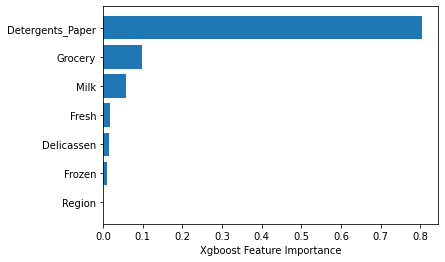

In [13]:
# Graphical represenation
sorted_idx = xgb_clf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb_clf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

**The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model.**

In [14]:
xgb_clf.get_booster().get_score(importance_type="gain")

{'Detergents_Paper': 36.228185483,
 'Milk': 2.5860216958999995,
 'Frozen': 0.398169696,
 'Grocery': 4.3999226099,
 'Delicassen': 0.651007652,
 'Fresh': 0.775874138}

**The Coverage metric means the relative number of observations related to this feature.**

In [15]:
xgb_clf.get_booster().get_score(importance_type="cover")

{'Detergents_Paper': 42.157176975,
 'Milk': 22.630639099999996,
 'Frozen': 25.2557516,
 'Grocery': 41.572331766666665,
 'Delicassen': 32.9062614,
 'Fresh': 17.3056488}

**The Frequency (R)/Weight (python) is the percentage representing the relative number of times a particular feature occurs in the trees of the model.**

In [16]:
xgb_clf.get_booster().get_score(importance_type="weight")

{'Detergents_Paper': 4,
 'Milk': 4,
 'Frozen': 2,
 'Grocery': 3,
 'Delicassen': 1,
 'Fresh': 1}

**The Gain is the most relevant attribute to interpret the relative importance of each feature.**

In [17]:
xgb_clf.get_booster().get_score(importance_type="total_gain")

{'Detergents_Paper': 144.912741932,
 'Milk': 10.344086783599998,
 'Frozen': 0.796339392,
 'Grocery': 13.199767829699999,
 'Delicassen': 0.651007652,
 'Fresh': 0.775874138}

### Alternative

SHAP value breaks a prediction value into contributions from each feature. It measures the impact of a feature on a single prediction value in comparison to the baseline prediction (mean of the target value for the training dataset)

In [18]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

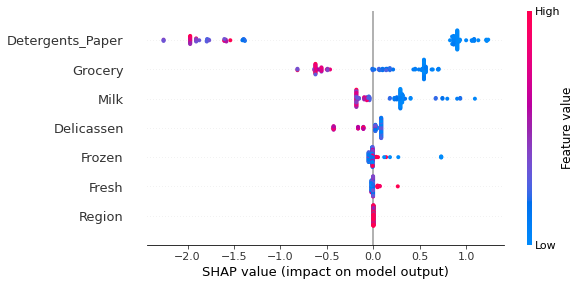

In [19]:
shap.summary_plot(shap_values, X_test)

The plot shows a cumulation of many dots. The dots have three characteristics:

- The vertical location of the dots show what feature they are depicting
- Color shows whether that feature value was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.